In [964]:
import pygame, time, tqdm
import sys, os, getopt, math, random
import numpy as np
from constants import *
import cv2 as cv

In [18]:
def check_amoeba(poses_t, poses, num_robots, step, thresh = 1):
    """
    Function to check if a given amoeboid swarm is amoeboid after movement of the swarm robots

    Args:
        poses_t (np.array): Original positions of the robots
        poses (np.array): New positions of teh robors
        num_robots (int): Number of robots currently in the swarm
        step (float): step moving distance
        thresh (float, optional): threshold value for centroid and distance from centroid conditions. Defaults to 1.

    Returns:
        bool: True if the new swarm is amoeboid, False otherwise
    """    
    centroid = getcenteroid(poses[:num_robots])
    centroid_t = getcenteroid(poses_t[:num_robots])
    # print(centroid)
    arr_radii = np.array([get_dist(centroid, p) for p in poses[:num_robots]])
    arr_radii_t = np.array([get_dist(centroid, p) for p in poses_t[:num_robots]])
    
    delta_centroid = get_dist(centroid, centroid_t)
    delta_radius = np.mean(arr_radii) - np.mean(arr_radii_t)
    
    if delta_centroid/step < thresh and delta_radius/np.mean(arr_radii_t) < thresh:
        return True
    return False
    
    

# Function to get centroid
def getcenteroid(arr):
    length, dim = arr.shape
    return np.array([np.sum(arr[:, i])/length for i in range(dim)])

def get_dist(p1, p2):
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

def euclidean_distance(a, b):
    """Euclidean Distance

    Args:
        a (np.array): a
        b (np.array): b

    Returns:
        float: dist
    """
    return np.linalg.norm(a-b)


In [19]:
# general function to steer robot away from wall if out of boundary (following physics)
# use global variable "world_side_length"
# def robot_boundary_check(robot_pos, robot_ori):
#     new_ori = robot_ori
#     if robot_pos[0] >= screen.get_width():  # 
#         print("outside of right boundary")
#         if math.cos(new_ori) > 0:
#             new_ori = reset_radian(2*(math.pi/2) - new_ori)
#             # further check if new angle is too much perpendicular
#             if new_ori > 0:
#                 if (math.pi - new_ori) < perp_thres:
#                     new_ori = new_ori - devia_angle
#             else:
#                 if (new_ori + math.pi) < perp_thres:
#                     new_ori = new_ori + devia_angle
#     elif robot_pos[0] <= 0:  # outside of left boundary
#         print("outside left")
#         if math.cos(new_ori) < 0:
#             new_ori = reset_radian(2*(math.pi/2) - new_ori)
#             if new_ori > 0:
#                 if new_ori < perp_thres:
#                     new_ori = new_ori + devia_angle
#             else:
#                 if (-new_ori) < perp_thres:
#                     new_ori = new_ori - devia_angle
#     if robot_pos[1] >= screen.get_height():  # outside of top boundary
#         print("outside of top boundary")
#         if math.sin(new_ori) > 0:
#             new_ori = reset_radian(2*(0) - new_ori)
#             if new_ori > -math.pi/2:
#                 if (new_ori + math.pi/2) < perp_thres:
#                     new_ori = new_ori + devia_angle
#             else:
#                 if (-math.pi/2 - new_ori) < perp_thres:
#                     new_ori = new_ori - devia_angle
#     elif robot_pos[1] <= 0:  # outside of bottom boundary
#         print("outside of bottom boundary")
#         if math.sin(new_ori) < 0:
#             new_ori = reset_radian(2*(0) - new_ori)
#             if new_ori > math.pi/2:
#                 if (new_ori - math.pi/2) < perp_thres:
#                     new_ori = new_ori + devia_angle
#             else:
#                 if (math.pi/2 - new_ori) < perp_thres:
#                     new_ori = new_ori - devia_angle
#     return new_ori

# general function to steer robot away from wall if out of boundary (in random direction)
# use global variable "world_side_length"
def robot_boundary_check(robot_pos, robot_ori):
    new_ori = robot_ori
    if robot_pos[0] >= world_side_length:  # outside of right boundary
        if math.cos(new_ori) > 0:
            new_ori = reset_radian(math.pi/2 + np.random.uniform(0,math.pi))
    elif robot_pos[0] <= 0:  # outside of left boundary
        if math.cos(new_ori) < 0:
            new_ori = reset_radian(-math.pi/2 + np.random.uniform(0,math.pi))
    if robot_pos[1] >= world_side_length:  # outside of top boundary
        if math.sin(new_ori) > 0:
            new_ori = reset_radian(-math.pi + np.random.uniform(0,math.pi))
    elif robot_pos[1] <= 0:  # outside of bottom boundary
        if math.sin(new_ori) < 0:
            new_ori = reset_radian(0 + np.random.uniform(0,math.pi))
    return new_ori

# general function to reset radian angle to [-pi, pi)
def reset_radian(radian):
    while radian >= math.pi:
        radian = radian - 2*math.pi
    while radian < -math.pi:
        radian = radian + 2*math.pi
    return radian

In [921]:
# calculate world_side_coef from a desired screen size for 30 robots
def cal_world_side_coef():
    desired_screen_size = 750  # desired screen size for 30 robots
    desired_world_size = float(desired_screen_size) / pixels_per_length
    return desired_world_size / pow(30, 1/power_exponent)
world_side_coef = cal_world_side_coef()
# world_side_length = world_side_coef * pow(swarm_size, 1/power_exponent)
world_side_length = world_side_coef * pow(30, 1/power_exponent)
world_size = (world_side_length, world_side_length)  # square physical world
# screen size calculated from world size
screen_side_length = int(pixels_per_length * world_side_length)
screen_size = (screen_side_length, screen_side_length)  # square display world

In [922]:
# Function to create a unit vector from a given vector
def unit_vector(vector):
    return np.abs(vector / np.linalg.norm(vector))
def get_swarm_vector(robot_oris):
    vector = np.array([0.0,0.0])
    for ori in robot_oris:
        vec = np.array([math.cos(ori), math.sin(ori)])
        vector += vec
    return vector

def get_radial_distance(robot_poses, current_swarm_size):
    centroid = np.array([np.sum(robot_poses[:, 0]), np.sum(robot_poses[:, 1])])/current_swarm_size
    radial_dist = 0
    for robot in range(current_swarm_size):
        radial_dist+= euclidean_distance(centroid, robot_poses[robot])
        
    return radial_dist

In [923]:
try:
    pygame.display.quit()
    pygame.quit()
except:
    pass
pygame.init()

font = pygame.font.SysFont("Cabin", 12)

screen = pygame.display.set_mode(screen_size)
pygame.display.set_caption("Demo 1")
# draw the network
screen.fill(color_white)

pygame.display.update()
def disp_poses_update():
    global disp_poses
    poses_temp = robot_poses / world_side_length
    poses_temp[:,1] = 1.0 - poses_temp[:,1]
    poses_temp = poses_temp * screen_side_length
    disp_poses = poses_temp.astype(int)  # convert to int and assign to disp_poses
    # disp_poses = np.array([[0,0] for i in range(swarm_size)])  # 
# disp_poses_update()


In [1059]:
def get_coverage(img):
    imgray = cv.cvtColor(img, cv.IMREAD_GRAYSCALE)
    count = 0
    for i in range(screen_side_length):
        for j in range(screen_side_length):
            if (imgray[i][j]!= 255).any():
                count+=1

    return count/(screen_side_length*screen_side_length)

def plot_swarm(robot_poses, robot_oris, disp_poses_t=None):
    # draw the network
    disp_poses_update()
    # screen.fill(color_white)
    for i in range(swarm_size):
        pygame.draw.circle(screen, color_black, disp_poses[i], robot_size_formation-1, 100)
        # pygame.draw.line(screen, color_grey, disp_poses[i], disp_poses[i]+np.array([math.cos(robot_oris[i]), math.sin(robot_oris[i])])*50)
        if disp_poses_t is not None:
            # pygame.draw.line(screen, color_black, disp_poses[i], disp_poses_t[i])
            pass
    pygame.display.update()
# plot_swarm(robot_poses, robot_oris)

def rebound_reflection(robot_pos, sensing_range):
    reflection = np.array([0.0, 0.0])
    if robot_pos[0] < sensing_range:
        reflection += np.array([world_side_length/4, 0.0])
    if world_side_length - robot_pos[0] < sensing_range:
        reflection += np.array([-world_side_length/4, 0.0])
    if robot_pos[1]< sensing_range:
        reflection += np.array([0.0, world_side_length/4])
    if world_side_length - robot_pos[1]< sensing_range:
        reflection += np.array([0.0, -world_side_length/4])
        
    return reflection

def reset_ori_random():
    return np.random.rand(swarm_size) * math.pi

def reset_ori():
    return np.array([np.random.rand()*math.pi for i in range(swarm_size)])

In [1060]:
np.random.seed(0)



In [1104]:
step = 0.12
swarm_size = 3
# init = 100
delta_c = 1.5
delta_r = 1.5
step_normal = 3.0
swarm_ori = np.random.random()*math.pi
sim_haulted = False
center = np.array([world_side_length/2, world_side_length/2])

reflection_vectors = np.array([[0.0,0.0] for i in range(swarm_size)])
reflection_counter = [0 for i in range(swarm_size)]
sensing_range = 0.5
reflection_counter_iter = 5


robot_poses = np.array([[1.0,1.0] for i in range(swarm_size)])  # initialize the robot poses
dist_table = np.zeros((swarm_size, swarm_size))  # distances between robots
conn_table = np.zeros((swarm_size, swarm_size))  # connections between robots
current_swarm_size = 1  # the current swarm size
robot_oris = np.random.rand(swarm_size) * math.pi   # in range of [0, pi/2)
past = []
screen.fill(color_white)

plot_swarm(robot_poses, robot_oris)

random_weight = 2.0
pseudopod_weight = 4.0
current_weight = 2.0
iter_counter = 0


reset_counter_val = 300

results = {}

In [1149]:
for iter in tqdm.trange(500):
    for event in pygame.event.get():
        if event.type == pygame.QUIT:  # close window button is clicked
            print("program exit in simulation 1")
            sys.exit()  # exit the entire program
        if event.type == pygame.KEYUP:
            if event.key == pygame.K_SPACE:
                sim_haulted = not sim_haulted  # reverse the pause flag
    # if sim_haulted: continue
    # print(f"Halted = {sim_haulted}, swarm size = {current_swarm_size}")
    # print(f"current swarm size is: {current_swarm_size} out of {swarm_size}")
    current_pos = robot_poses[0]
    centroid = np.array([np.sum(robot_poses[:, 0]), np.sum(robot_poses[:, 1])])/current_swarm_size
    # print(centroid)
    
    if iter_counter % reset_counter_val<5:
        robot_oris = reset_ori()
    if iter_counter % reset_counter_val==5:
        robot_oris = reset_ori_random()
    disp_poses_t = disp_poses.copy()
    robot_poses_t = robot_poses.copy()  # stores the old copy of robot positions
    if current_swarm_size == 0: pass #continue
    elif current_swarm_size < 3:
        old_centroid = np.array([1,1])
        # random_vector = unit_vector((np.random.rand(2)-0.5)*2)
        for j in range(current_swarm_size):
        
            robot_oris[j] = robot_boundary_check(robot_poses_t[j], robot_oris[j])
            robot_poses[j] = robot_poses_t[j] + (step/5 * np.array([math.cos(robot_oris[j]), math.sin(robot_oris[j])]))
            past.append((robot_poses[j], robot_poses_t[j]))
        old_centroid = centroid
        changed_distance = euclidean_distance(old_centroid, centroid)
        old_radial = get_radial_distance(robot_poses, current_swarm_size)
        
    else:
        # Add robot to swarm
        if current_swarm_size < swarm_size:

            j = current_swarm_size
            robot_oris[j] = robot_boundary_check(robot_poses_t[j], robot_oris[j])
            robot_poses[j] = robot_poses_t[j] + (step * np.array([math.cos(robot_oris[j]), math.sin(robot_oris[j])]))
        
        # Pseudopod Grouping
        non_moving = []
        robot_ids = list(range(current_swarm_size))
        
        for div in range(current_swarm_size//3):
            init = np.random.choice(robot_ids)
            # print("Robot chosen is: ", init)
            robot_ids.remove(init)
            closest = S14_closest_robot(init, robot_ids)
            robot_ids.remove(closest)
            # print("closest robot id is: ", closest)
            
            # Choose another robot that is closest to the two
            closest1 = S14_closest_robot(init, robot_ids)
            closest2 = S14_closest_robot(closest, robot_ids)
            if closest1 == closest2:
                triad = [init, closest, closest1]
                robot_ids.remove(closest1)
            else:
                if dist_table[init, closest1] < dist_table[closest, closest2]:
                    triad = [init, closest, closest1]
                    robot_ids.remove(closest1)
                else:
                    triad = [init, closest, closest2]
                    robot_ids.remove(closest2)
            # print("triad is: ", triad) # Direction of Last robot in this list is updated, other two are pseudopods
            non_moving.extend([triad[0], triad[1]])
            dist = [euclidean_distance(robot_poses[triad[i]], centroid) for i in range(len(triad))]
            
            # dist.sort(reverse=True)
            vector1 = np.array([math.cos(robot_oris[triad[0]]), math.sin(robot_oris[triad[0]])])
            vector2 = np.array([math.cos(robot_oris[triad[1]]), math.sin(robot_oris[triad[1]])])
            
            current_vector = np.array([math.cos(robot_oris[triad[2]]), math.sin(robot_oris[triad[2]])])
            random_ori = np.random.random()* 2* math.pi
            random_vector = np.array([math.cos(random_ori), math.sin(random_ori)])
            centroid_vector = np.array(centroid) - np.array(robot_poses[triad[2]])
            avg_vector = get_swarm_vector(robot_oris)
            
            vector = pseudopod_weight*np.random.random()*(vector1 + vector2) + current_weight * np.random.random()* current_vector + np.random.random() * centroid_vector + np.random.random() * avg_vector + random_weight * np.random.random()*random_vector
            
            
            robot_oris[triad[2]] = math.atan2(vector[1], vector[0])


            step_dist = 0
            coord_old = robot_poses[triad[2]]
            
            sum_coord = sum(robot_poses[:current_swarm_size])
            
            curr_reflection = rebound_reflection(robot_poses[triad[2]], sensing_range)
            if (curr_reflection != np.array([0.0,0.0])).any():
                robot_oris[triad[2]] = math.atan2(curr_reflection[1], curr_reflection[0])
                robot_poses[triad[2]] = robot_poses_t[triad[2]] + (step * np.array([math.cos(robot_oris[triad[2]]), math.sin(robot_oris[triad[2]])]))
            else:
                for step_candidate in np.linspace(step, step/2, 10):
                    new_pos = robot_poses_t[triad[2]] + (step_candidate * np.array([math.cos(robot_oris[triad[2]]), math.sin(robot_oris[triad[2]])]))
                    new_centroid = np.array(np.sum(new_pos), np.sum(new_pos))/current_swarm_size
                    # print(euclidean_distance(old_centroid, centroid))
                    if euclidean_distance(new_centroid, centroid)/changed_distance < delta_c:
                        break
                
            changed_distance = euclidean_distance(new_centroid, centroid) - euclidean_distance(old_centroid, centroid)
            robot_poses[triad[2]] = new_pos
            centroid = np.array([np.sum(robot_poses[:, 0]), np.sum(robot_poses[:, 1])])/current_swarm_size
            past.append((robot_poses[triad[2]], robot_poses_t[triad[2]]))
            

        curr_radial_dist = get_radial_distance(robot_poses, current_swarm_size)
        # print("robots left are ",robot_ids+non_moving)
        
        robot_ids.sort(key=lambda x: get_dist(centroid, robot_poses[x]), reverse=True)
        for robot in robot_ids+non_moving:
            current_vector = np.array([math.cos(robot_oris[robot]), math.sin(robot_oris[robot])])
            centroid_vector = np.array(centroid) - np.array(robot_poses[robot])
            random_ori = np.random.random()* 2* math.pi
            random_vector = np.array([math.cos(random_ori), math.sin(random_ori)])
            final_vector = current_weight* np.random.random()* current_vector + np.random.random()*centroid_vector+ random_weight*np.random.random()*random_vector
            
            ori = math.atan2(final_vector[1], final_vector[0])
            curr_reflection = rebound_reflection(robot_poses[robot], sensing_range)
            if (curr_reflection != np.array([0.0,0.0])).any():
                robot_oris[robot] = math.atan2(curr_reflection[1], curr_reflection[0])
            
            else:
                for step_candidate in np.linspace(step, step/2, 10):
                    new_pos = robot_poses_t[robot] + (step_candidate * np.array([math.cos(ori), math.sin(ori)]))
                    new_radial = curr_radial_dist - euclidean_distance(centroid, robot_poses_t[robot])+ euclidean_distance(centroid, new_pos)
                    
                    if (new_radial)/old_radial < delta_r:
                        robot_poses[robot] = new_pos
                        past.append((robot_poses[robot], robot_poses_t[robot]))
                        break
                        robot_poses_t[robot] + (step * np.array([math.cos(ori), math.sin(ori)]))

            centroid = np.array([np.sum(robot_poses[:, 0]), np.sum(robot_poses[:, 1])])/current_swarm_size
            
        
        old_radial = new_radial
    old_centroid = centroid
    prev = robot_poses_t[:(current_swarm_size-1)] if current_swarm_size < swarm_size else robot_poses_t
    
    # if iter_counter % 10 == 0:
    #     pygame.image.save(screen, "swarm"+str(iter_counter)+".png")
    
    
    if current_swarm_size < swarm_size:
        current_swarm_size+=1 
    iter_counter+=1
    plot_swarm(robot_poses, robot_oris, disp_poses_t)
    # pygame.image.save(screen, 'img/swarm.png')
    # # get_coverage(cv.imread('swarm.png'))
    
    # if iter_counter % 20 == 0:
    #     results[iter_counter] = get_coverage(cv.imread('img/swarm.png'))
    

100%|██████████| 500/500 [00:02<00:00, 245.22it/s]


In [1086]:
pygame.image.save(screen, "swarm.png")

In [1150]:
robot_poses

array([[14.54873675, 14.3511033 ],
       [ 2.69637147, 14.51715635],
       [ 2.69637147, 14.51715635]])

: 

In [642]:
robot_oris, iter_counter


(array([ 0.        , -1.57079633, -1.57079633, -1.57079633, -1.57079633,
        -1.57079633, -1.57079633, -1.57079633, -1.57079633, -1.57079633]),
 265)

In [348]:
screen.fill(color_white)
pygame.display.update()

In [347]:
plot_swarm(robot_poses, robot_oris)

In [346]:
robot_poses = np.array([(10.0, 10.0)])
disp_poses_update()
screen.fill(color_white)
swarm_size=len(robot_poses)
plot_swarm(robot_poses, robot_oris)
disp_poses

array([[500,   0]])

# 0,0 => 0,500
# 10,0 => 500, 500
# 0, 10 => 0, 0
# 10, 10 => 500, 0

In [412]:
def change(x, y):
    return (x/world_side_length)*screen_side_length, (1.0-y/world_side_length)*screen_side_length

In [413]:
print(change(0,0),change(10,0),change(0,10),change(10,10))

(0.0, 500.0) (500.0, 500.0) (0.0, 0.0) (500.0, 0.0)


In [410]:
world_side_length

10.0

In [210]:
robot_poses

array([[3.01047938e+00, 5.29539113e+02],
       [2.00602099e+00, 5.30852795e+02],
       [2.79661049e+00, 5.32289499e+02],
       [2.82456915e+00, 5.27426253e+02],
       [2.56908210e+00, 5.30810584e+02],
       [2.47966739e+00, 5.34525464e+02],
       [2.35706071e+00, 5.33409803e+02],
       [3.93148912e-01, 6.87735246e+00],
       [2.89683430e-01, 2.12437243e+00],
       [2.26707424e+00, 5.39985136e+02]])

In [1054]:
data = []
for key, val in results.items():
    data.append([key, val*100])

In [1055]:
df = pd.DataFrame(data, columns=['iteration', 'coverage'])

<AxesSubplot:>

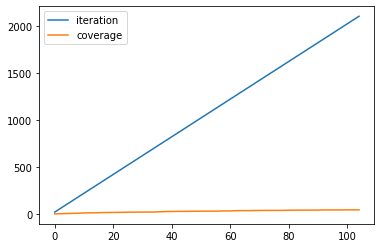

In [1056]:
df.plot()

In [1057]:
df

,iteration,coverage
0,20,0.932267
1,40,1.960178
2,60,2.922667
3,80,4.044444
4,100,4.859378
...,...,...
100,2020,43.739200
101,2040,44.112711
102,2060,44.209067
103,2080,44.219200


In [1058]:
df.to_csv('results.csv')